In [ ]:
"""
3/15/2021

EDA on new features
(features from YOLO detected eyes, ears, nose)


"""

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white")

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score, log_loss

## Load data and create df
* .csv files already include both blurriness and face info (with more details)
* larger dataset(1832 rows)

In [2]:
bad = pd.read_csv('./OpenCV_blur/TEST_face_features_bad_bare.csv')
good = pd.read_csv('./OpenCV_blur/TEST_face_features_good_bare.csv')

len(bad),len(good)

(808, 1024)

In [3]:
test = pd.concat([bad,good],axis=0).reset_index(drop=True)
# test

In [4]:
import ast
# Convert to actual list and count number of eyes/ears/nose detected
test['eyes'] = test['eyes'].apply(lambda x: ast.literal_eval(x))
test['num_eye'] = test['eyes'].apply(lambda x: len(x))
test['ears'] = test['ears'].apply(lambda x: ast.literal_eval(x))
test['num_ear'] = test['ears'].apply(lambda x: len(x))
test['nose'] = test['nose'].apply(lambda x: ast.literal_eval(x))
test['num_nose'] = test['nose'].apply(lambda x: len(x))

# eye position
test['eye_x1'] = test['eyes'].apply(lambda x: x[0][0] if (len(x)>0) else 100000)
test['eye_y1'] = test['eyes'].apply(lambda x: x[0][1] if (len(x)>0) else 100000)
test['eye_x2'] = test['eyes'].apply(lambda x: x[1][0] if (len(x)>1) else 100000)
test['eye_y2'] = test['eyes'].apply(lambda x: x[1][1] if (len(x)>1) else 100000)
# eye width
test['eye_w1'] = test['eyes'].apply(lambda x: x[0][2] if (len(x)>0) else 100000)
test['eye_w2'] = test['eyes'].apply(lambda x: x[1][2] if (len(x)>1) else 100000)
test['eye_w'] = test['eyes'].apply(lambda x: sum([x[i][2] for i in range(len(x))])/len(x) if len(x)!=0 else 100000)
# eye height
test['eye_h1'] = test['eyes'].apply(lambda x: x[0][3] if (len(x)>0) else 100000)
test['eye_h2'] = test['eyes'].apply(lambda x: x[1][3] if (len(x)>1) else 100000)
test['eye_h'] = test['eyes'].apply(lambda x: sum([x[i][3] for i in range(len(x))])/len(x) if len(x)!=0 else 100000)
# eye size and ratio compared to face
test['eye_size'] = test['eye_w']*test['eye_h']
test['eye_ratio'] = test['eye_size'] / test['face_size']

# nose position
test['nose_x'] = test['nose'].apply(lambda x: x[0][0] if (len(x)>0) else 100000)
test['nose_y'] = test['nose'].apply(lambda x: x[0][1] if (len(x)>0) else 100000)

# ear width
test['ear_w1'] = test['ears'].apply(lambda x: x[0][2] if (len(x)>0) else 100000)
test['ear_w2'] = test['ears'].apply(lambda x: x[1][2] if (len(x)>1) else 100000)
test['ear_w'] = test['ears'].apply(lambda x: sum([x[i][2] for i in range(len(x))])/len(x) if len(x)!=0 else 100000)
# ear height
test['ear_h1'] = test['ears'].apply(lambda x: x[0][3] if (len(x)>0) else 100000)
test['ear_h2'] = test['ears'].apply(lambda x: x[1][3] if (len(x)>1) else 100000)
test['ear_h'] = test['ears'].apply(lambda x: sum([x[i][3] for i in range(len(x))])/len(x) if len(x)!=0 else 100000)


# Generate features to address face angle
test['en_x1'] = abs(test['eye_x1'] - test['nose_x'])
test['en_x2'] = abs(test['eye_x2'] - test['nose_y'])
test['en_x_delta'] = abs(test['en_x1'] - test['en_x2'])
test['angle_x'] = test['en_x_delta'].apply(lambda x: 0 if x>90000 else 1)

test['en_y1'] = abs(test['eye_y1'] - test['nose_x'])
test['en_y2'] = abs(test['eye_y2'] - test['nose_y'])
test['en_y_delta'] = abs(test['en_y1'] - test['en_y2'])
test['angle_y'] = test['en_y_delta'].apply(lambda x: 0 if x>90000 else 1)

In [5]:
pd.set_option('display.max_columns', None)

# Add 'label' as the last column
label_list = ['bad']*bad.shape[0] + ['good']*good.shape[0]
test['label'] = label_list
test.drop(columns=['eyes','ears','nose']).iloc[:,:]

,filename,lp_cat,lp_all,lp_ratio,lp_cat_canny,lp_all_canny,lp_ratio_canny,blur,to_ctr,cat_x,cat_y,face_size,size_ratio,num_eye,num_ear,num_nose,eye_x1,eye_y1,eye_x2,eye_y2,eye_w1,eye_w2,eye_w,eye_h1,eye_h2,eye_h,eye_size,eye_ratio,nose_x,nose_y,ear_w1,ear_w2,ear_w,ear_h1,ear_h2,ear_h,en_x1,en_x2,en_x_delta,angle_x,en_y1,en_y2,en_y_delta,angle_y,label
0,IMG_0185.MOV_12.jpg,5.052993,151.810569,0.033285,13687.793353,20847.260510,0.656575,0,189.620674,0.638889,0.439583,43681,0.021065,0,0,0,100000,100000,100000,100000,100000,100000,100000.0,100000,100000,100000.0,1.000000e+10,228932.487809,100000,100000,100000,100000,100000.0,100000,100000,100000.0,0,0,0,1,0,0,0,1,bad
1,IMG_0185.MOV_156.jpg,12.748102,61.145684,0.208487,10715.795177,6489.486205,1.651255,0,383.255789,0.224074,0.374479,112896,0.054444,1,0,0,447,819,100000,100000,77,100000,77.0,95,100000,95.0,7.315000e+03,0.064794,100000,100000,100000,100000,100000.0,100000,100000,100000.0,99553,0,99553,0,99181,0,99181,0,bad
2,IMG_0185.MOV_162.jpg,34.031338,53.224166,0.639396,5607.710122,2606.958020,2.151055,0,381.430203,0.291667,0.339583,130321,0.062848,2,0,0,379,758,532,757,89,84,86.5,95,89,92.0,7.958000e+03,0.061065,100000,100000,100000,100000,100000.0,100000,100000,100000.0,99621,99468,153,1,99242,99243,1,1,bad
3,IMG_0185.MOV_168.jpg,35.830179,78.479448,0.456555,7468.365741,11896.382691,0.627785,0,585.511742,0.120370,0.282292,145924,0.070372,2,1,1,197,643,364,658,96,88,92.0,108,90,99.0,9.108000e+03,0.062416,288,789,163,100000,163.0,189,100000,189.0,91,425,334,1,355,131,224,1,bad
4,IMG_0185.MOV_174.jpg,33.939300,125.446714,0.270548,7138.382092,26640.493901,0.267952,0,509.231774,0.105556,0.354687,151321,0.072975,1,0,0,180,805,100000,100000,105,100000,105.0,100,100000,100.0,1.050000e+04,0.069389,100000,100000,100000,100000,100000.0,100000,100000,100000.0,99820,0,99820,0,99195,0,99195,0,bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1827,joined_video_54ba02eb70fc40e4a4d6dd164fd11e70....,21.401767,126.141180,0.169665,14373.143661,4680.821614,3.070645,0,251.872984,0.438889,0.155556,41209,0.079493,2,1,1,348,163,440,173,49,40,44.5,45,47,46.0,2.047000e+03,0.049674,399,231,112,100000,112.0,94,100000,94.0,51,209,158,1,236,58,178,1,good
1828,joined_video_54ba02eb70fc40e4a4d6dd164fd11e70....,20.284242,133.398163,0.152058,12532.716580,4792.583325,2.615023,0,266.443240,0.450000,0.133333,47089,0.090835,2,0,1,364,158,455,164,51,43,47.0,51,49,50.0,2.350000e+03,0.049905,417,225,100000,100000,100000.0,100000,100000,100000.0,53,230,177,1,259,61,198,1,good
1829,joined_video_54ba02eb70fc40e4a4d6dd164fd11e70....,21.238435,129.968949,0.163412,13780.555614,5021.751296,2.744173,0,256.007812,0.497222,0.144444,42849,0.082656,2,1,1,393,155,481,158,52,41,46.5,46,46,46.0,2.139000e+03,0.049919,444,218,116,100000,116.0,92,100000,92.0,51,263,212,1,289,60,229,1,good
1830,joined_video_54ba02eb70fc40e4a4d6dd164fd11e70....,20.905433,124.860466,0.167430,14052.346956,4535.443542,3.098340,0,271.812435,0.470833,0.123611,42436,0.081860,2,0,1,373,151,468,151,53,37,45.0,46,44,45.0,2.025000e+03,0.047719,432,207,100000,100000,100000.0,100000,100000,100000.0,59,261,202,1,281,56,225,1,good


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1832 entries, 0 to 1831
Data columns (total 48 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   filename        1832 non-null   object 
 1   lp_cat          1832 non-null   float64
 2   lp_all          1832 non-null   float64
 3   lp_ratio        1832 non-null   float64
 4   lp_cat_canny    1832 non-null   float64
 5   lp_all_canny    1832 non-null   float64
 6   lp_ratio_canny  1832 non-null   float64
 7   blur            1832 non-null   int64  
 8   to_ctr          1832 non-null   float64
 9   cat_x           1832 non-null   float64
 10  cat_y           1832 non-null   float64
 11  face_size       1832 non-null   int64  
 12  size_ratio      1832 non-null   float64
 13  eyes            1832 non-null   object 
 14  ears            1832 non-null   object 
 15  nose            1832 non-null   object 
 16  num_eye         1832 non-null   int64  
 17  num_ear         1832 non-null   i

## EDA

### 1. Histogram

In [7]:
def quick_hist(x):
    plt.rcParams['figure.figsize'] = [20, 8]
    fig, ax = plt.subplots()
    sns.histplot(data=test, x=x, hue='label', multiple='stack')
    ax.set_title("Histogram of bad and good frames",fontsize=20)
    ax.set_ylabel('Count',fontsize=20)
    ax.set_xlabel(x,fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=14)
    plt.legend(['good','bad'],fontsize=20);

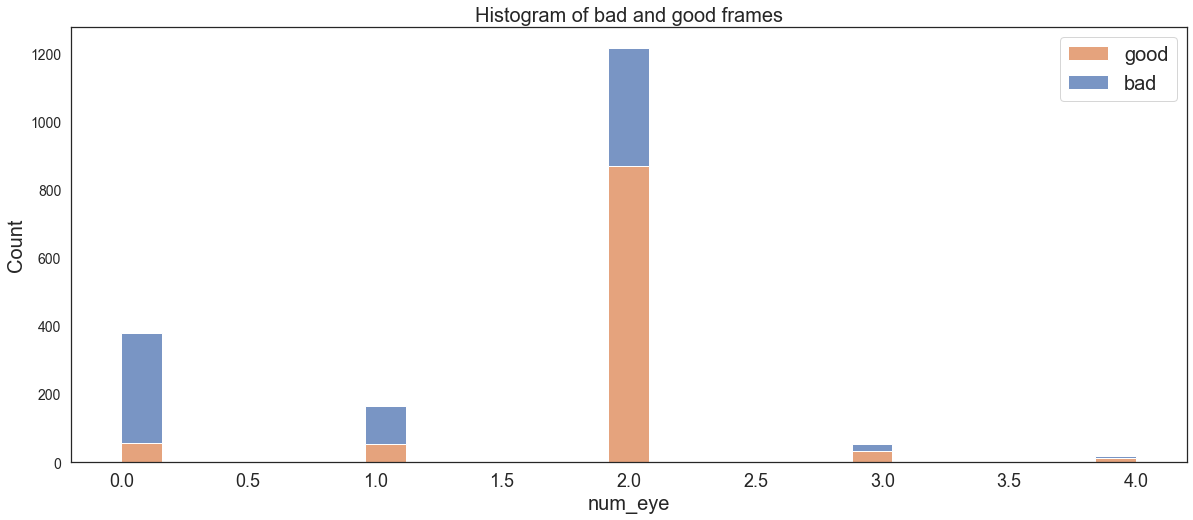

In [8]:
quick_hist('num_eye');

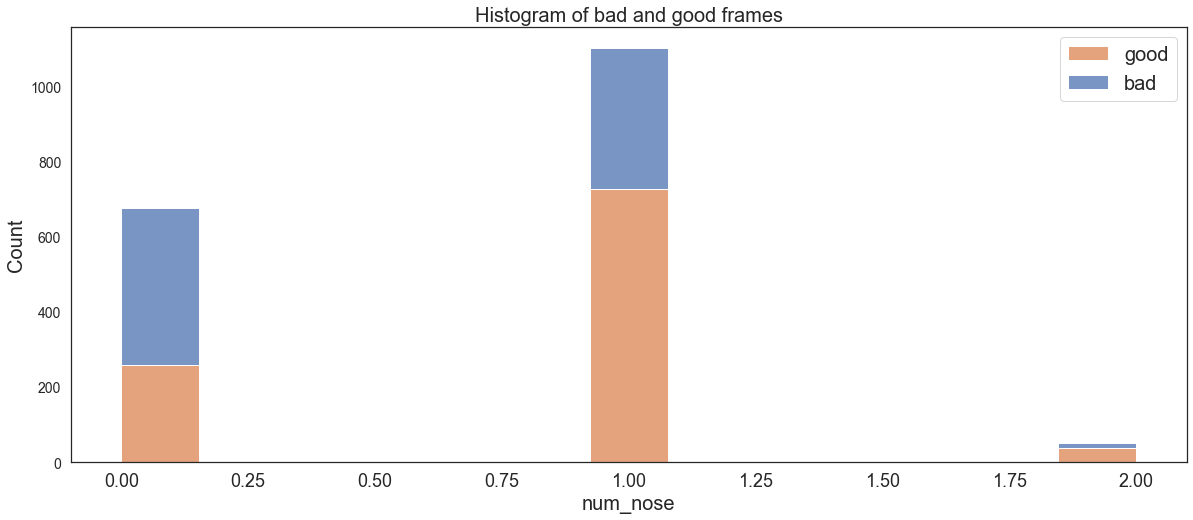

In [9]:
quick_hist('num_nose');

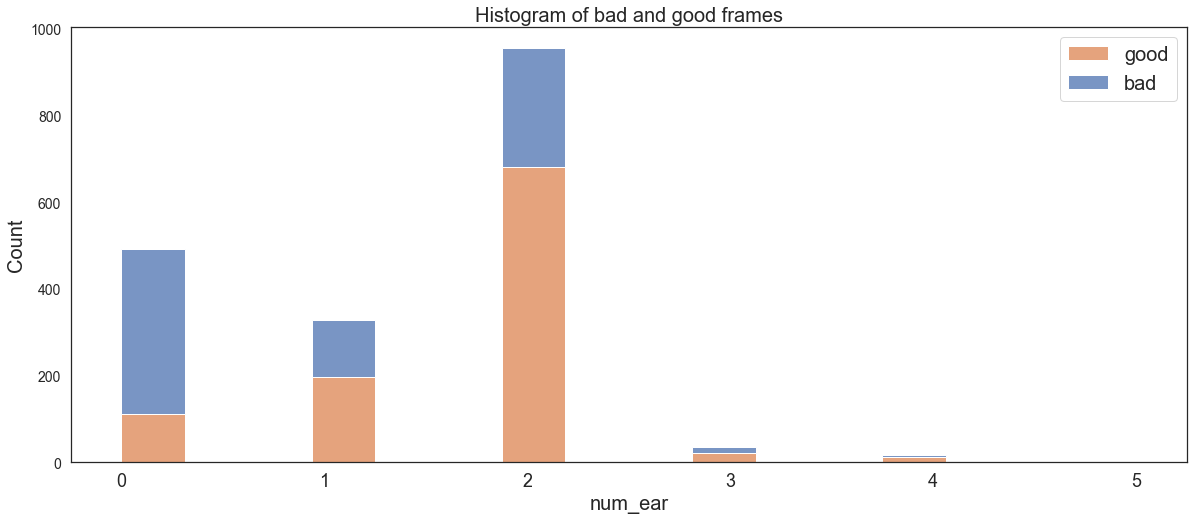

In [10]:
quick_hist('num_ear');

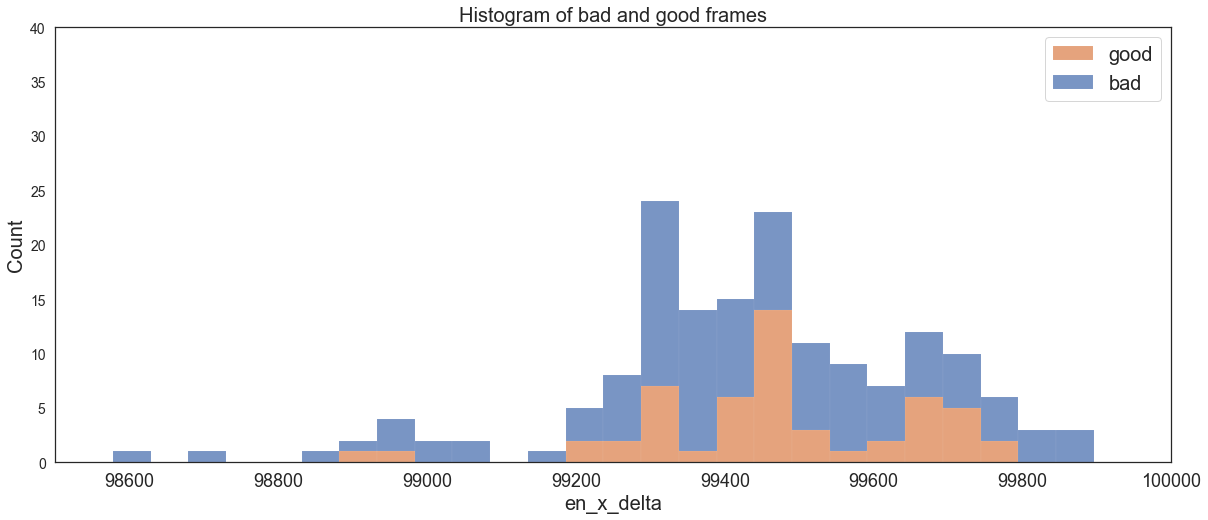

In [11]:
quick_hist('en_x_delta');
plt.xlim([98500,100000])
plt.ylim([0,40]);

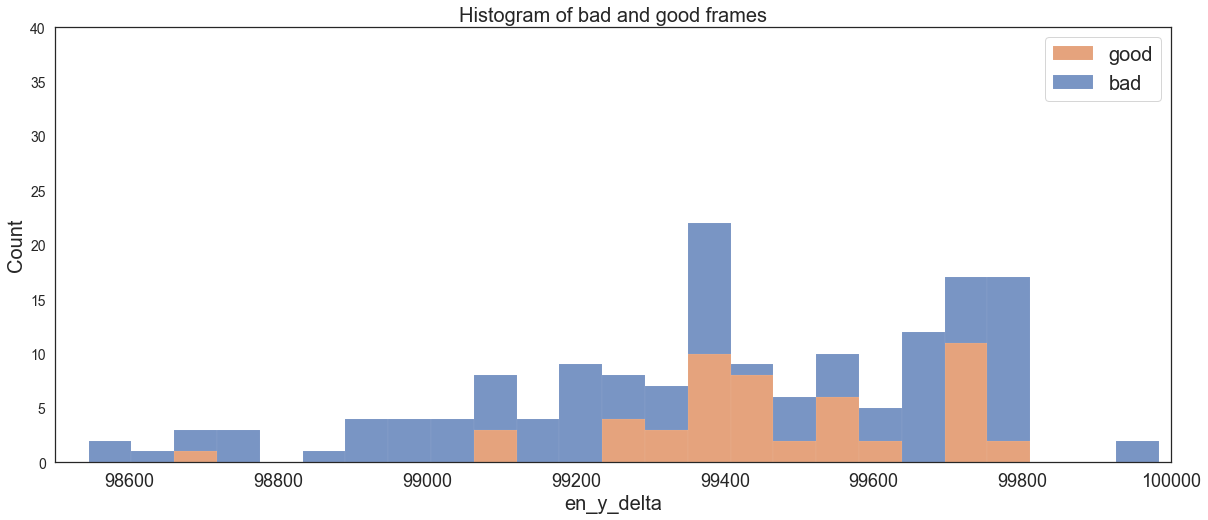

In [12]:
quick_hist('en_y_delta');
plt.xlim([98500,100000])
plt.ylim([0,40]);

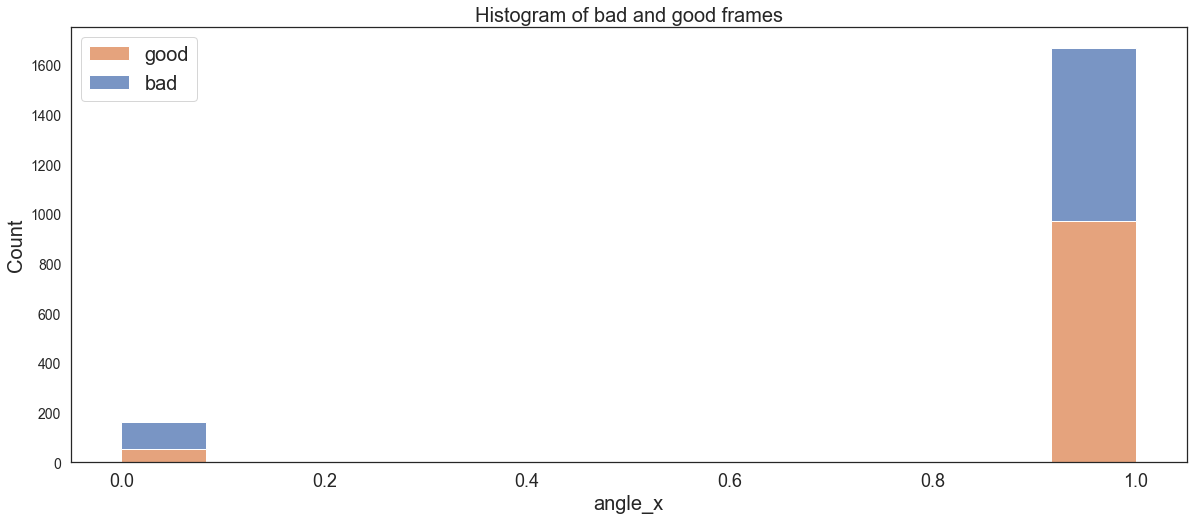

In [13]:
quick_hist('angle_x');

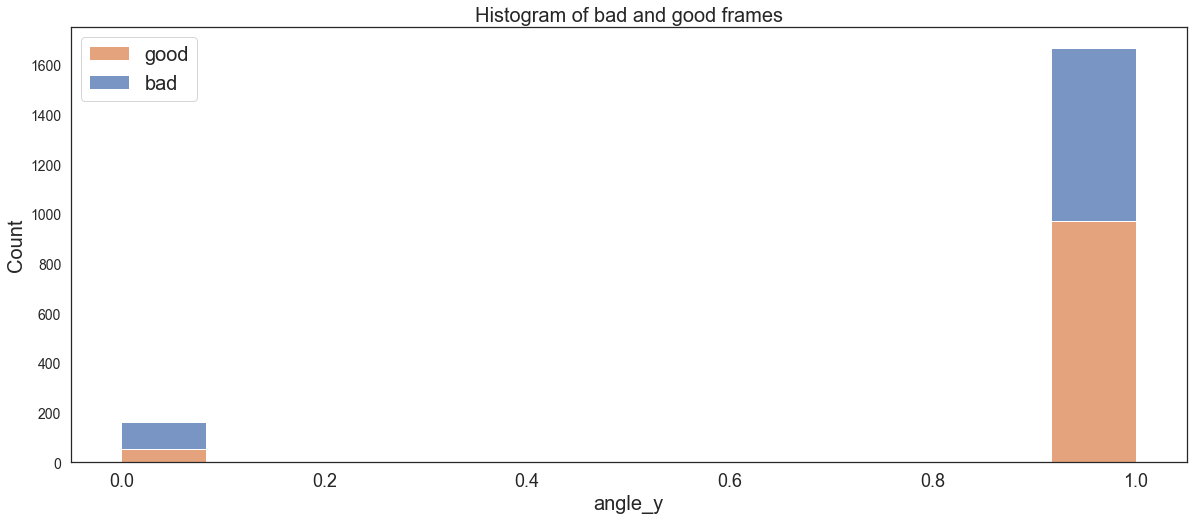

In [14]:
quick_hist('angle_y');

### 2. Scatter plots

In [15]:
def quick_plot(x,y):
    plt.rcParams['figure.figsize'] = [20, 8]
    fig, ax = plt.subplots()
    sns.scatterplot(x=x,y=y,data=test,hue='label', s=100, alpha=.6)
    ax.set_title("Distribution of bad and good frames",fontsize=20)
    ax.set_ylabel(y,fontsize=20)
    ax.set_xlabel(x,fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=20);

### 1. Laplacian and Canny edges

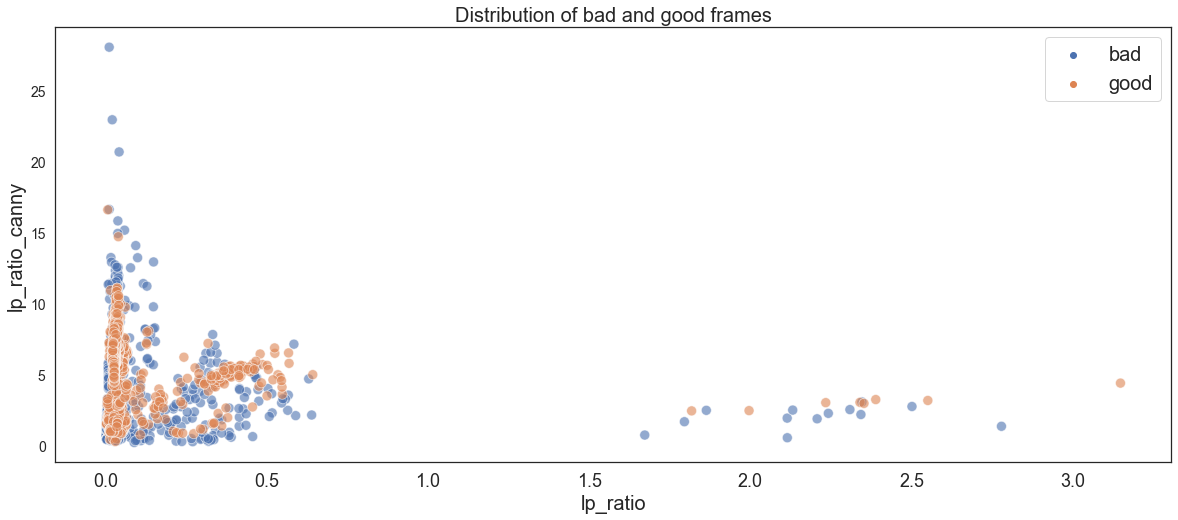

In [16]:
quick_plot('lp_ratio','lp_ratio_canny')

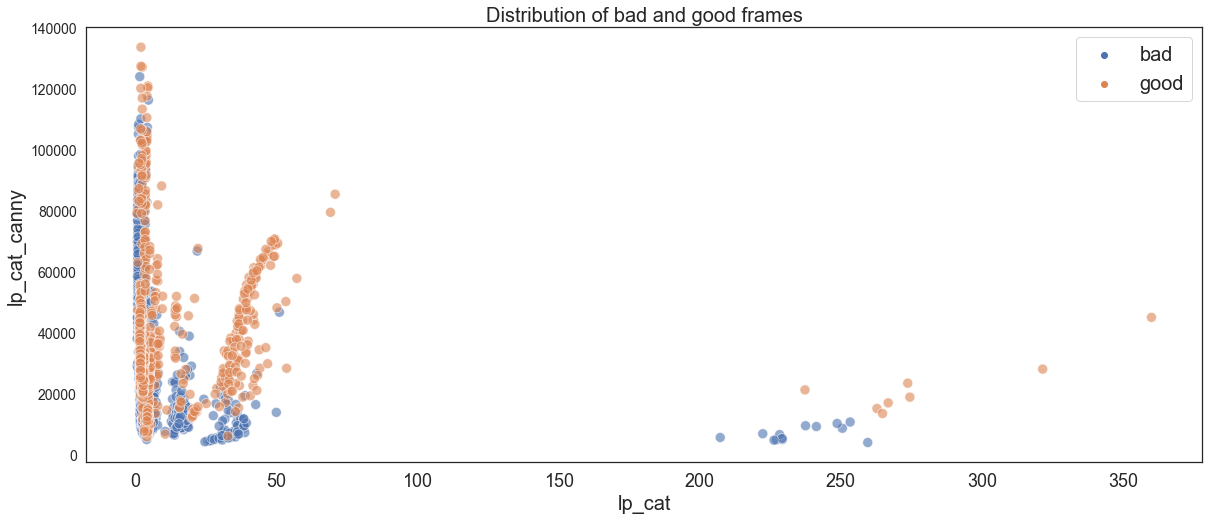

In [17]:
quick_plot('lp_cat','lp_cat_canny')

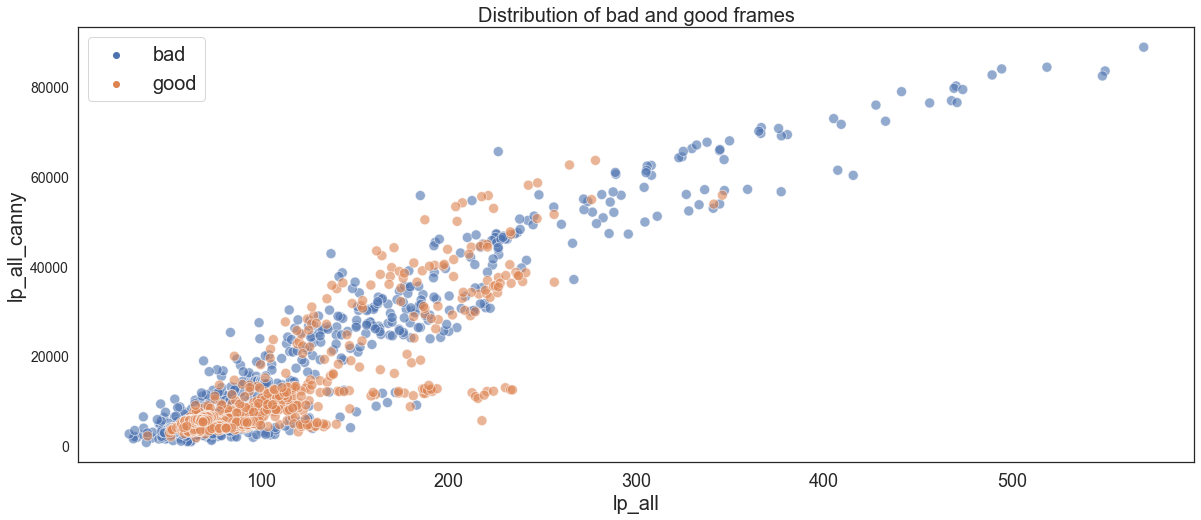

In [18]:
quick_plot('lp_all','lp_all_canny')

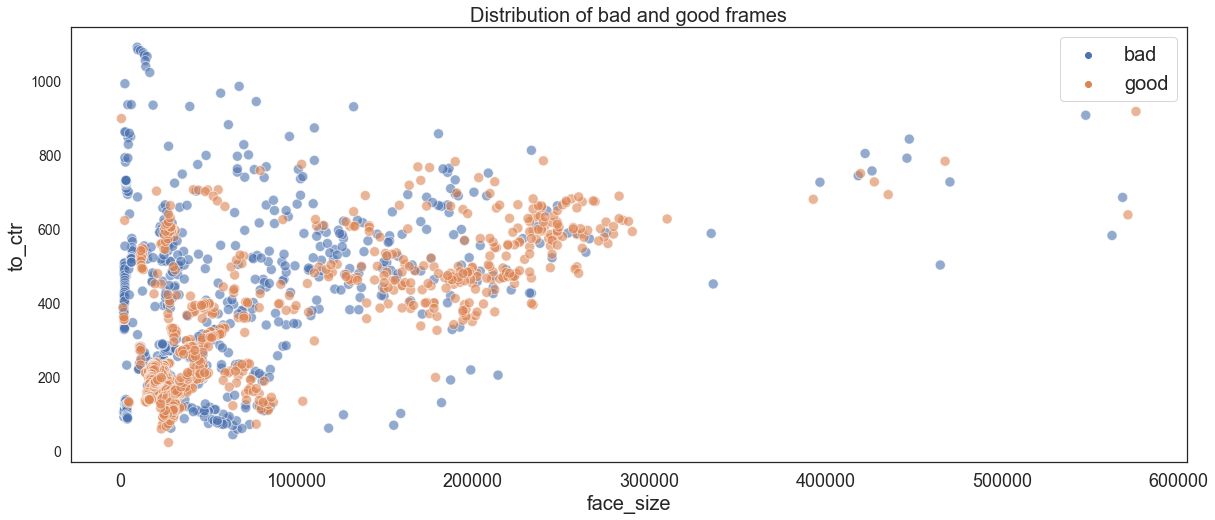

In [19]:
quick_plot('face_size','to_ctr')

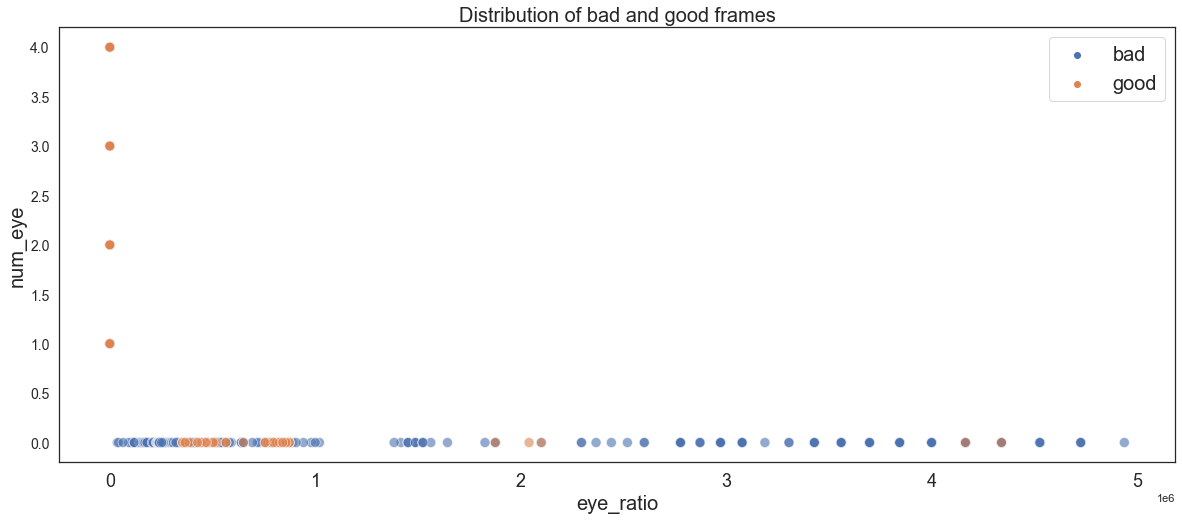

In [20]:
quick_plot('eye_ratio','num_eye')

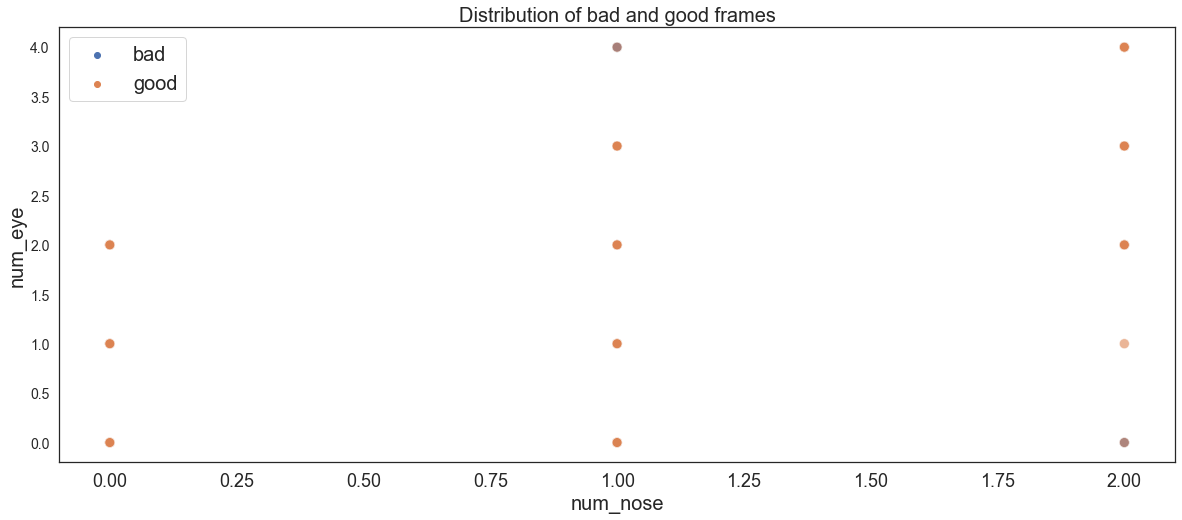

In [21]:
quick_plot('num_nose','num_eye')